In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import random
import matplotlib.pyplot as plt
%matplotlib inline

### Paper definitions:
Enhancer paper = "Enhancer Identification from DNA sequence using Transfer and Adversarial Deep Learning"  
triple GAN = "Triple Generative Adversarial Nets"

### Loading the data

In [2]:
#TODO

### Scratchpad

In [3]:

kernel_shape=[4,9]
input_channels = 1
num_kernels = 20

weights_shape = kernel_shape + [input_channels, num_kernels]
print(weights_shape)
print([1] + [2, 2] + [1])
print(int(500/8))

[4, 9, 1, 20]
[1, 2, 2, 1]
62


### Defining helper functions


In [4]:
def conv_layer(name_scope, input_tensor, num_kernels, kernel_shape,
               stride=1, padding="VALID", relu=True, 
               batch_normalize=False, batch_normalize_training=True, 
               name_suffix=None):
    """
    Return a convolution layer, possibly with a ReLU at the end.
    :param name_scope:   where the variables live
    :param input_tensor: of shape [batch, in_height, in_width, in_channels], e.g. [15 500 4 1]
    :param num_kernels:  number of kernels to use for this conv. layer
    :param kernel_shape: the shape of the kernel to use, [height, width]
    """
    name_suffix = name_suffix if name_suffix else ""
    
    #E.g. batch_size x 500x4x1 for the first input
    input_shape = input_tensor.get_shape().as_list()
    input_channels = input_shape[-1]
    
    #not really sure why I'm using the name_scope, I think it's mostly for presentation purposes
    with tf.name_scope(name_scope):
        
        weights_shape = kernel_shape + [input_channels, num_kernels]
        init_vals_weights = tf.truncated_normal(weights_shape, stddev=math.sqrt(2 / float(input_channels)))
        filter_weights = tf.Variable(init_vals_weights, name='weights'+name_suffix)
    
        biases = tf.Variable(tf.zeros([num_kernels]), name='biases'+name_suffix)
        
        #Define a convolutional layer
        layer = tf.nn.conv2d(input_tensor, filter_weights, strides=[1, stride, stride, 1], padding=padding) + biases
        
        #TODO: batch_normalization layer
        
        #Add (leaky) ReLU if specified
        if relu and lrelu:
            layer = tf.nn.leaky_relu(layer, name="lrelu_"+name_suffix)
        elif relu:
            layer = tf.nn.relu(layer, name="relu_"+name_suffix)
            
        return layer

    
def max_pool_layer(name_scope, input_tensor, pool_size, strides = None, padding="SAME"):
    """
    Return a max pool layer.
    """
    if not strides:
        strides = [1] + pool_size + [1]
       
    #TODO: is name_scope really needed?
    with tf.name_scope(name_scope):
        layer = tf.nn.max_pool(input_tensor, [1] + pool_size + [1], strides=strides, padding=padding)
        return layer


def dropout_layer(name_scope, input_tensor, keep_prob=0.5):
    """
    Return a dropout layer.
    """
    #TODO: is name_scope really needed?
    with tf.name_scope(name_scope)
        return tf.nn.droupout(input_tensor, keep_prob)

SyntaxError: invalid syntax (<ipython-input-4-0e5d861c9457>, line 59)

In [54]:
def prepare_classifier(dna_sequence):
    """
    Return the same classifier, with architecture the same as they used in Enhancer paper.
    """
    # 20 filters, each of size batch x 4x9x1
    # TODO: make a reverse filter conv layer like in the Enhancer paper 
    l1 =  conv_layer(data, name_scope="layer1", num_kernels=20, kernel_shape=[4, 9], relu=True)
    #TODO finish

def discriminator(dna_sequence, label_one_hot=None, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
    # TODO: make a reverse filter conv layer like in the Enhancer paper 
    # convolutional + pooling #1
    l1 = conv_layer(data, name_scope="conv1", num_kernels=20, kernel_shape=[4, 9], relu=True)
    l2 = max_pool_layer(l1, name_scope="pool1", pool_size=[1, 3])
    
    # convolutional + pooling #2
    l3 = conv_layer(l2, name_scope="conv2", num_kernels=30, kernel_shape=[1, 5])
    l4 = max_pool_layer(l3, name_scope="pool2", pool_size=[1, 4])
    
    # convolutional + pooling #3
    l5 = conv_layer(l4, name_scope="conv3", num_kernels=40, kernel_shape=[1, 3])
    l6 = max_pool_layer(l5, name_scope="pool3", pool_size=[1, 4])
    
    # fully connected
    num_hidden = 90
    l7 = tf.layers.dense(inputs=l6, units=num_hidden)
    
    num_hidden = 45
    l8 = tf.layers.dense(inputs=l7, units=num_hidden)
    
    logits = tf.layers.dense(inputs=l8, units=2)
    return tf.nn.softmax(logits, name="softmax_tensor")
    
def generator(noise_vector, batch_size, label_one_hot=None, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 1 #dimensionality of the output
        s = 500 #Final length of the sequence
        
        #We want to slowly upscale the sequence, so these values should help
        # to make that change gradual
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16)
                                                                  
        width = 4 #because we have 4 letters: ATCG
        
        #this is a magic number which I'm not sure what means yet
        magic_number = 5
        
        h0 = tf.reshape(noise_vector, [batch_size, s16, width/4, magic_number])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 31 x 1 x magic_number

        #First DeConv Layer
        output1_shape = [batch_size, s8, width/2, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(value=h0, filter=W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME', name="H_conv1") + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, 
                                               scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 62 x 1 x 256
        print("H_conv1:")
        print(H_conv1.shape)
        
        
        #Second DeConv Layer
        output2_shape = [batch_size, s4-1, width/2, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 2, 1, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, 
                                               scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 124 x 2 x 128
        print("H_conv2:")
        print(H_conv2.shape)
        
        #Third DeConv Layer
        output3_shape = [batch_size, s2-2, width, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, 
                                               scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 248 x 4 x 64
        print("H_conv3:")
        print(H_conv3.shape)
        
        #Fourth DeConv Layer
        output4_shape = [batch_size, s, width*2, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 2, 1, 1], padding='VALID') + b_conv4
        H_conv4 = tf.nn.tanh(H_conv4)
        print("H_conv4:")
        print(H_conv4.shape)
        #Dimensions of H_conv4 = batch_size x 500 x 4 x 1
    return H_conv4

### Show a sample sequence

H_conv1:
(1, 62, 2, 256)
H_conv2:
(1, 124, 2, 128)
H_conv3:
(1, 248, 4, 64)
H_conv4:
(1, 500, 8, 1)
READY TO RUN SESS
(500, 8)


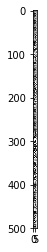

In [55]:
tf.reset_default_graph()
sess = tf.Session()

z_dimensions = 155
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
sample_sequence = generator(z_test_placeholder, 1)
test_z = np.random.normal(-1, 1, [1,z_dimensions])

train_writer = tf.summary.FileWriter('./train',
                                      sess.graph)
print("READY TO RUN SESS")
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_sequence, feed_dict={z_test_placeholder: test_z}))

my_seq = temp.squeeze()

print(my_seq.shape)
plt.imshow(my_seq, cmap='gray_r')
plt.show()

# Note: below is taken from [the tutorial here](https://github.com/uclaacmai/Generative-Adversarial-Network-Tutorial.git) (and modified)

### Assemble components (discriminator, generator, classifier)

In [ ]:
#TODO: adjust to our needs
sess = tf.Session()
z_dimensions = 5120
batch_size = 16
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()

x_placeholder = tf.placeholder("float", shape = [None,500,4,1]) #Placeholder for input sequences to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #Placeholder for input noise vectors to the generator
label_placeholder = tf.placeholder("int", shape= [None, 1, 2, 1]) #Placeholder for one-hot-encoded label

Dx = discriminator(x_placeholder, label_placeholder) #Dx will hold discriminator prediction probabilities for the real input sequences
Gz = generator(z_placeholder,label_placeholder, batch_size, z_dimensions) #Gz holds the generated sequences
Dg = discriminator(Gz, label_placeholder, reuse=True) #Dg will hold discriminator prediction probabilities for generated sequences


### Specify loss

In [ ]:
#TODO: specify the right losses etc

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg))) # ensure forward compatibility: function needs to have logits and labels args explicitly used

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake


### Specify optimizers

In [ ]:
#TODO: adjust to our needs
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print(tf.get_variable_scope().reuse)
adam = tf.train.AdamOptimizer()
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)

### Train the stuff

In [ ]:
#TODO: make it compatible with our dataset

sess.run(tf.global_variables_initializer())
iterations = 3000
for i in range(iterations):
    z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)
    real_image_batch = np.reshape(real_image_batch[0],[batch_size,28,28,1])
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch}) #Update the discriminator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator 